In [1]:
import warnings
warnings.simplefilter("ignore")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from scipy.io import savemat
from scipy.fft import fftfreq, fftshift, fftn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from tqdm import tqdm

from utils import NeuralNet, create_ds, poisson, calculate_N
import argparse

In [2]:
def parse_arguments():
    parser = argparse.ArgumentParser(description="Initialize and train the network.")

    # Network initialization arguments
    parser.add_argument(
        "--num_stages", type=int, required=True, help="Number of stages in the network."
    )
    parser.add_argument(
        "--num_hidden_layers", type=int, required=True, help="Number of hidden layers per stage."
    )
    parser.add_argument(
        "--num_hidden_nodes", type=int, required=True, help="Number of hidden nodes per layer."
    )
    parser.add_argument(
        "--dim", type=int, required=True, help="Dimensionality of the input data."
    )

    # Training parameters
    parser.add_argument(
        "--N_train", type=int, required=True, help="Number of training samples."
    )

    # Optional sample_sizes list argument
    parser.add_argument(
        "--sample_sizes",
        type=int,
        nargs="*",
        help="List of sample sizes, one for each stage. Must match the number of stages.",
    )

    args = parser.parse_args()

    # Validate sample_sizes if provided
    if args.sample_sizes and len(args.sample_sizes) != args.num_stages:
        parser.error(
            f"--sample_sizes must have exactly {args.num_stages} elements, one for each stage."
        )

    return args

In [3]:
class MultistageNeuralNetwork:
    """
    MultistageNeuralNetwork is a multi-stage model used for predicting
    high-dimensional function outputs through regression. This class encapsulates
    the functionality for constructing, training, and predicting using a sequence
    of neural networks, where each stage of the network can focus on different
    aspects of the data.

    Attributes:
        dim (int): Dimensionality of the input data.
        N (int): Number of points per dimension in the dataset.
        stages (list): List of neural networks, one for each stage.
        layers (list): Architecture of the neural network (input layer, hidden layers, output layer).
        lt (list): Minimum values for each dimension in the input data.
        ut (list): Maximum values for each dimension in the input data.
    """

    def __init__(self, x_train, num_stages, num_hidden_layers, num_hidden_nodes):
        """
        Initialize the MultistageNeuralNetwork instance.

        Args:
            x_train (tf.Tensor): Input training data.
            num_stages (int): Number of stages in the multi-stage neural network.
            num_hidden_layers (int): Number of hidden layers in each stage.
            num_hidden_nodes (int): Number of nodes in each hidden layer.
        """
        self.dim = x_train.shape[-1]                                 # Number of dimensions in the input data.
        self.N = int(round(x_train.shape[0] ** (1 / self.dim)))      # Number of points per dimension.
        self.stages = [None] * num_stages                            # List to store each stage's neural network.
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1]  # Neural network architecture.
        self.lt = [tf.math.reduce_min(x_train[:, i]) for i in range(x_train.shape[-1])]  # Min values for each dimension.
        self.ut = [tf.math.reduce_max(x_train[:, i]) for i in range(x_train.shape[-1])]  # Max values for each dimension.

    # @staticmethod
    # def sample(x_train, y_train, step):
    #     """
    #     Downsample the dataset and corresponding labels by selecting evenly spaced points.

    #     Args:
    #         x_train (tf.Tensor): Input data points.
    #         y_train (tf.Tensor): Corresponding labels.
    #         step (int): Interval for sampling points.

    #     Returns:
    #         tuple: Downsampled data points and corresponding labels.
    #     """
    #     dim = x_train.shape[-1]
    #     N = int(round(x_train.shape[0] ** (1 / dim)))
    #     reshaped_x = tf.reshape(x_train, [N] * dim + [dim])  # Reshape into a grid format.
    #     reshaped_y = tf.reshape(y_train, [N] * dim)          # Reshape labels accordingly.

    #     slices = tuple(slice(0, N, step) for _ in range(dim))  # Create slices for even spacing.
    #     sampled_grid = reshaped_x[slices + (slice(None),)]     # Extract evenly spaced grid points.
    #     sampled_y = reshaped_y[slices]                        # Extract corresponding labels.

    #     sampled_points = tf.reshape(sampled_grid, (-1, dim))  # Flatten the sampled grid.
    #     sampled_y = tf.reshape(sampled_y, (-1, 1))            # Flatten the sampled labels.

    #     print(f"Sampled data size: {sampled_points.shape}, Sampled labels size: {sampled_y.shape}")
    #     return sampled_points, sampled_y

    def train(self, x_train, y_train, stage, kappa, iters):
        """
        Train a specific stage of the neural network.

        Args:
            x_train (tf.Tensor): Input training data.
            y_train (tf.Tensor): Corresponding labels for training.
            stage (int): The stage index to train.
            kappa (float): Scaling factor for activation.
            iters (list): Number of iterations for [Adam optimizer, L-BFGS optimizer].
        """
        act = 0 if stage == 0 else 1  # Use different activation for first stage.
        lt = [tf.cast(tf.math.reduce_min(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        ut = [tf.cast(tf.math.reduce_max(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]

        self.stages[stage] = NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act)
        self.stages[stage].train(iters[0], 1)  # Train using Adam optimizer.
        self.stages[stage].train(iters[1], 2)  # Train using L-BFGS optimizer.

    @staticmethod
    def fftn_(x_train, residue):
        """
        Perform a Fast Fourier Transform (FFT) to analyze the frequency domain of the residue.

        Args:
            x_train (tf.Tensor): Input training data.
            residue (tf.Tensor): Residual errors between predictions and true values.

        Returns:
            float: Adjusted scaling factor (kappa) based on the dominant frequency.
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy()

        GG = g.reshape([N_train] * dim)  # Reshape residue into a grid.
        G = fftn(GG)                    # Perform FFT.
        G_shifted = fftshift(G)         # Shift zero-frequency component to the center.

        N = len(G)
        total_time_range = 2  # Time range from -1 to 1.
        sample_rate = N / total_time_range  # Sampling rate.

        half_N = N // 2
        T = 1.0 / sample_rate
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]  # Extract positive frequencies.

        freqs = [fftshift(fftfreq(GG.shape[i], d=T)) for i in range(len(GG.shape))]
        freq_pos = [freqs[i][half_N:] for i in range(len(freqs))]

        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(len(freq_pos))]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)  # Normalize magnitude.

        dominant_freq = max(dominant_freqs)
        print(f"Sample rate = {sample_rate} Hz, Dominant Frequency = {dominant_freq} Hz, Magnitude = {magnitude}")

        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.0001
        print(f"New Kappa: {kappa_f}")
        return kappa_f, dominant_freq


In [36]:
def poisson(x_train):
    N_f = x_train.shape[0]
    dim = x_train.shape[-1]
    coeffs = 1 # used to be random from 1 to dim - 1
    const_2 = 1
    x_radius = 1

    xf = x_train.numpy() # used to be random points of size (N_f, args.dim) normalized by sqrt(sum(squares))
    x = xf

    u1 = x_radius**2 - np.sum(x**2, 1, keepdims=True)
    du1_dx = -2 * x
    d2u1_dx2 = -2

    if dim == 1: x1, x2 = x, x  # Reshape 1D array to 2D array with one column
    else: x1, x2 = x[:, :-1], x[:, 1:]
    u2 = coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1))
    u2 = np.sum(u2, 1, keepdims=True)
    du2_dx_part1 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
            (1 - x2 * np.sin(x1))
    du2_dx_part2 = coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * \
            (-const_2 * np.sin(x2) + np.cos(x1))
    du2_dx = np.zeros((N_f, dim))
    du2_dx[:, :-1] += du2_dx_part1
    du2_dx[:, 1:] += du2_dx_part2
    d2u2_dx2_part1 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (1 - x2 * np.sin(x1))**2 + \
            coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (- x2 * np.cos(x1))
    d2u2_dx2_part2 = -coeffs * np.sin(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.sin(x2) + np.cos(x1))**2 + \
            coeffs * np.cos(x1 + const_2 * np.cos(x2) + x2 * np.cos(x1)) * (-const_2 * np.cos(x2))
    d2u2_dx2 = np.zeros((N_f, dim))
    d2u2_dx2[:, :-1] += d2u2_dx2_part1
    d2u2_dx2[:, 1:] += d2u2_dx2_part2
    ff = u1 * d2u2_dx2 + 2 * du1_dx * du2_dx + u2 * d2u1_dx2
    ff = np.sum(ff, 1)
    u = (u1 * u2).reshape(-1)
    ff = ff + np.sin(u)

    ff = tf.convert_to_tensor(ff, dtype=tf.float64)  
    return ff

In [37]:
# Create train and eval data
dim = 1
N_train = int(round(1600 ** (1 / dim)))
N_eval = int(round(5000 ** (1 / dim)))
x_train = create_ds(dim, -1.02, 1.02, N_train)
y_train = tf.reshape(poisson(x_train), [len(x_train), 1])
# x_eval = create_ds(dim, -1.02, 1.02, N_eval)
# y_eval = tf.reshape(poisson(x_eval), [len(x_eval), 1])
print(y_train)

tf.Tensor(
[[ 1.74971663]
 [ 1.7454682 ]
 [ 1.74121816]
 ...
 [-1.77927843]
 [-1.7817914 ]
 [-1.78431201]], shape=(1600, 1), dtype=float64)


In [18]:
# Compute Prediction for one dataset (dim = 2)
num_stages = 4
num_hidden_layers = 3
num_hidden_nodes = 20
L = 2.04

training_iters = list([(3000, 7000)] + [(5000, 7000*i) for i in range(2, 10)])[:num_stages]

MSNN = MultistageNeuralNetwork(x_train, num_stages, num_hidden_layers, num_hidden_nodes)
kappa = 1
print(f"******** TRAINING STAGE {0} ********")
print(f"Data size: {x_train.shape}, Label size: {y_train.shape}")

MSNN.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])
curr_residue = y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(1)])

for i in range(1, num_stages):
    print(f"******** TRAINING STAGE {i} ********")
    kappa, f_max = MultistageNeuralNetwork.fftn_(x_train, curr_residue)
    N_train = calculate_N(f_max, L)
    x_train = create_ds(dim, -1.02, 1.02, N_train)
    y_train = tf.reshape(poisson(x_train), [len(x_train), 1])
    print(f"N_train: {N_train}, Data size: {x_train.shape}, Label size: {y_train.shape}")

    curr_residue = y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(i)])
        
    MSNN.train(x_train, curr_residue, stage=i, kappa=kappa, iters=training_iters[i])

******** TRAINING STAGE 0 ********
Data size: (1024, 5), Label size: (1024, 1)


LBFGS Optimization:  43%|████▎     | 2993/7000 [00:37<00:48, 82.30iter/s]

Mode: LBFGSIter: 3000, loss: 8.5837e-01


LBFGS Optimization:  86%|████████▌ | 5998/7000 [01:13<00:11, 84.12iter/s]

Mode: LBFGSIter: 6000, loss: 4.5192e-01


LBFGS Optimization:  99%|█████████▊| 6901/7000 [01:24<00:01, 81.62iter/s]


******** TRAINING STAGE 1 ********
Sample rate = 2.0 Hz, Dominant Frequency = 0.5 Hz, Magnitude = 0.033719488539845965
New Kappa: 3.141592653589793
N_train: 4, Data size: (1024, 5), Label size: (1024, 1)


LBFGS Optimization:  21%|██▏       | 2995/14000 [00:38<02:21, 77.72iter/s]

Mode: LBFGSIter: 3000, loss: 7.7980e-04


LBFGS Optimization:  43%|████▎     | 5993/14000 [01:16<01:41, 78.74iter/s]

Mode: LBFGSIter: 6000, loss: 2.7683e-04


LBFGS Optimization:  64%|██████▍   | 8992/14000 [01:53<01:00, 82.60iter/s]

Mode: LBFGSIter: 9000, loss: 1.1742e-04


LBFGS Optimization:  86%|████████▌ | 11992/14000 [02:29<00:24, 82.69iter/s]

Mode: LBFGSIter: 12000, loss: 8.1004e-05


LBFGS Optimization: 100%|█████████▉| 13980/14000 [02:53<00:00, 80.56iter/s]


******** TRAINING STAGE 2 ********
Sample rate = 2.0 Hz, Dominant Frequency = 0.5 Hz, Magnitude = 0.033719488539845965
New Kappa: 3.141592653589793
N_train: 4, Data size: (1024, 5), Label size: (1024, 1)


LBFGS Optimization:  14%|█▍        | 2997/21000 [00:38<03:56, 76.04iter/s]

Mode: LBFGSIter: 3000, loss: 2.2536e-07


LBFGS Optimization:  29%|██▊       | 5998/21000 [01:16<03:13, 77.55iter/s]

Mode: LBFGSIter: 6000, loss: 4.2115e-08


LBFGS Optimization:  43%|████▎     | 8995/21000 [01:53<02:27, 81.41iter/s]

Mode: LBFGSIter: 9000, loss: 2.0615e-08


LBFGS Optimization:  57%|█████▋    | 11992/21000 [02:30<01:55, 78.27iter/s]

Mode: LBFGSIter: 12000, loss: 1.1692e-08


LBFGS Optimization:  71%|███████▏  | 14996/21000 [03:07<01:13, 81.61iter/s]

Mode: LBFGSIter: 15000, loss: 8.3861e-09


LBFGS Optimization:  86%|████████▌ | 17997/21000 [03:44<00:36, 81.91iter/s]

Mode: LBFGSIter: 18000, loss: 6.4578e-09


LBFGS Optimization:  99%|█████████▊| 20696/21000 [04:17<00:03, 80.28iter/s]

******** TRAINING STAGE 3 ********
Sample rate = 2.0 Hz, Dominant Frequency = 0.5 Hz, Magnitude = 0.0006844274912019261
New Kappa: 3.141592653589793
N_train: 4, Data size: (1024, 5), Label size: (1024, 1)



LBFGS Optimization:  11%|█         | 2998/28000 [00:36<05:10, 80.54iter/s]

Mode: LBFGSIter: 3000, loss: 1.6646e-11


LBFGS Optimization:  21%|██▏       | 5996/28000 [01:13<04:24, 83.23iter/s]

Mode: LBFGSIter: 6000, loss: 4.1476e-12


LBFGS Optimization:  32%|███▏      | 8995/28000 [01:49<03:52, 81.80iter/s]

Mode: LBFGSIter: 9000, loss: 2.4430e-12


LBFGS Optimization:  43%|████▎     | 11999/28000 [02:26<03:16, 81.56iter/s]

Mode: LBFGSIter: 12000, loss: 1.7002e-12


LBFGS Optimization:  54%|█████▎    | 14994/28000 [03:03<02:35, 83.58iter/s]

Mode: LBFGSIter: 15000, loss: 1.2418e-12


LBFGS Optimization:  64%|██████▍   | 17991/28000 [03:41<02:04, 80.39iter/s]

Mode: LBFGSIter: 18000, loss: 1.0068e-12


LBFGS Optimization:  75%|███████▍  | 20999/28000 [04:18<01:25, 82.21iter/s]

Mode: LBFGSIter: 21000, loss: 7.9805e-13


LBFGS Optimization:  86%|████████▌ | 23991/28000 [04:55<00:48, 82.42iter/s]

Mode: LBFGSIter: 24000, loss: 6.2744e-13


LBFGS Optimization:  96%|█████████▋| 26992/28000 [05:32<00:11, 84.61iter/s]

Mode: LBFGSIter: 27000, loss: 5.3852e-13


LBFGS Optimization: 100%|█████████▉| 27983/28000 [05:44<00:00, 81.27iter/s]


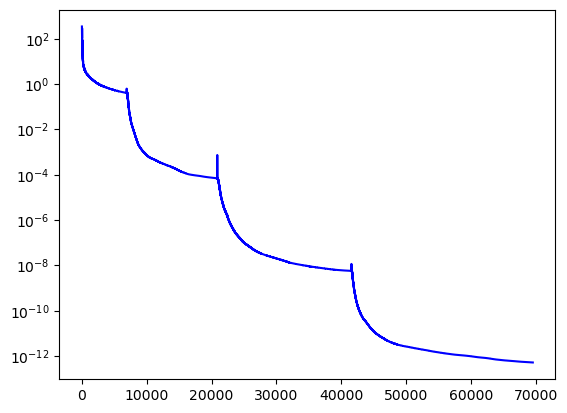

In [19]:
model1, model2, model3, model4 = MSNN.stages[0], MSNN.stages[1], MSNN.stages[2], MSNN.stages[3]
loss = np.array(model1.loss + model2.loss + model3.loss + model4.loss)
plt.figure()
plt.plot(loss, 'b-')
plt.yscale("log")

In [ ]:
if __name__ == "__main__":
    args = parse_arguments()

    print("Parsed arguments")